In [286]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost.sklearn import XGBRegressor

from plotnine import *
%matplotlib inline
import matplotlib.pyplot as plt

In [285]:
import sys
!pip3 install xgboost==0.7.post4

     |████████████████████████████████| 474 kB 3.2 MB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-0.7.post4-cp37-cp37m-macosx_10_14_x86_64.whl size=1251765 sha256=f87e7b62ebd2f5947029f7d0dcbc8c592b7402b2ac5a6ad4521e45d9ba8a2187
  Stored in directory: /Users/dengshuyang/Library/Caches/pip/wheels/38/79/5a/1891b7a08b632df79c8d679bdb1cb72648fb05910e6e82c532
Successfully built xgboost


# Load R-preprocessed ALS data

In [5]:
als_final = pd.read_csv('ALS_FINAL.csv', index_col=0)

# Split train and test dataset

In [9]:
als_final.columns

Index(['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing',
       'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'Q10_Respiratory', 'ALSFRS_Delta', 'ALSFRS_Total',
       'ALSFRS_Slope', 'famhis', 'Age', 'Ethnicity', 'Race_Caucasian', 'Sex',
       'Study_Arm', 'Onset_Delta', 'Bulbar_Onset', 'Limb_Bulbar_Onset',
       'Limb_Onset', 'Spine_Onset', 'Other_Onset',
       'FVC_Subject_Liters_Trial_1', 'Forced_Vital_Capacity_Delta',
       'Blood_Pressure_Diastolic', 'Blood_Pressure_Systolic', 'Pulse',
       'Respiratory_Rate', 'Temperature', 'Weight', 'Vital_Signs_Delta', 'AEC',
       'ALT', 'AST', 'Blood.Urea.Nitrogen..BUN.', 'Chloride', 'Creatinine',
       'Glucose', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Potassium', 'RBC',
       'Sodium', 'WBC'],
      dtype='object')

In [124]:
als_final['ALSFRS_Slope'].min()

-0.49999999999999895

### Keep als_12 untouched until making final prediction

In [10]:
als_3 = als_final[(als_final['ALSFRS_Delta'] >= 0) & (als_final['ALSFRS_Delta'] <= 90)]
als_12 = als_final[(als_final['ALSFRS_Delta'] > 90) & (als_final['ALSFRS_Delta'] <= 366)]

In [14]:
als_3.shape

(633, 49)

In [15]:
als_12.shape

(3421, 49)

In [24]:
X = als_3.drop(['subject_id', 'ALSFRS_Slope'],axis=1)
y = als_3['ALSFRS_Slope']

In [30]:
X.shape

(633, 47)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [252]:
X_als12 =als_12.drop(['subject_id', 'ALSFRS_Slope'], axis=1)
y_als12 = als_12['ALSFRS_Slope']

# Scale and dimensionality reduction

In [265]:
# scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [266]:
X_train_scaled

array([[7.50000000e-01, 7.50000000e-01, 1.00000000e+00, ...,
        2.71061729e-06, 4.96478873e-01, 2.42622951e-01],
       [0.00000000e+00, 5.00000000e-01, 2.50000000e-01, ...,
        2.29425288e-06, 4.15978630e-01, 2.89429056e-01],
       [7.50000000e-01, 1.00000000e+00, 5.00000000e-01, ...,
        2.36298943e-06, 3.92018779e-01, 5.73770492e-01],
       ...,
       [2.50000000e-01, 5.00000000e-01, 5.00000000e-01, ...,
        2.40183826e-06, 4.27277953e-01, 2.24610238e-01],
       [5.00000000e-01, 5.00000000e-01, 5.00000000e-01, ...,
        3.01864199e-06, 4.13639733e-01, 3.83904620e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.54428396e-06, 4.92957746e-01, 2.22950820e-01]])

In [83]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_scaled)

In [102]:
X_val_reduced = pca.transform(X_val_scaled)

In [84]:
pca.n_components_

25

In [85]:
X_train_reduced.shape

(569, 25)

In [86]:
np.sum(pca.explained_variance_ratio_)

0.9544065720832176

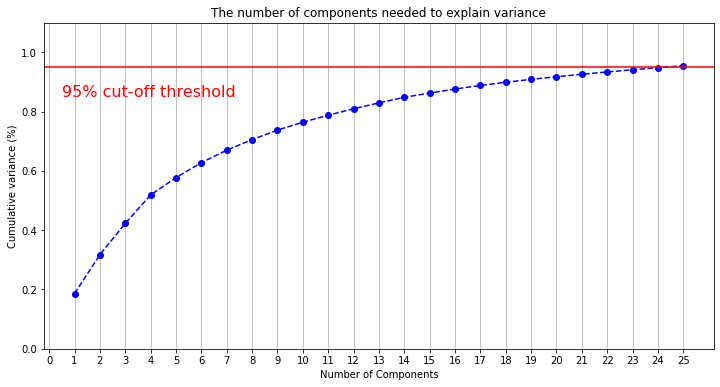

In [87]:
plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1,26,step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 26, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

# Train different models, predict, and evaluate

## Random forest

In [93]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [94]:
rnd_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(estimator = rnd_reg, param_distributions=random_grid,
                               n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rnd_search.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [96]:
print(rnd_search.best_params_)

{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 60, 'bootstrap': False}


In [105]:
best_model = rnd_search.best_estimator_
val_pred = best_model.predict(X_val_reduced)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_rmse

0.08986370484355159

In [125]:
train_mse = mean_squared_error(y_train, best_model.predict(X_train_reduced))
train_rmse = np.sqrt(train_mse)
train_rmse

0.029990637598505707

In [110]:
feat_labels = list(X_train.columns)

In [271]:
# pipeline for random forest
best_model = rnd_search.best_estimator_
rnd_pipeline = Pipeline((
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('rnd_reg', RandomForestRegressor(n_estimators=600, min_samples_split=2, min_samples_leaf=4,
                                     max_features='log2', max_depth=60, bootstrap=False)),
))

rnd_pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rnd_reg',
                 RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                       criterion='mse', max_depth=60,
                                       max_features='log2', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=600, n_jobs=None,
                                       oob_s

In [272]:
rnd_pipeline.predict(X_val)

array([-0.01608203, -0.04033302, -0.0537161 , -0.05179977, -0.05471165,
       -0.09089914, -0.09861718, -0.03459989, -0.04459834, -0.06568264,
       -0.07725575, -0.05508015, -0.02347151, -0.02902384, -0.10810949,
       -0.04036205, -0.05964025, -0.03844372, -0.06166476, -0.06463776,
       -0.05478563, -0.04527669, -0.06694169, -0.08998567, -0.02335858,
       -0.05393766, -0.06662274, -0.04857043, -0.05384202, -0.05707875,
       -0.05203287, -0.03761901, -0.09642392, -0.0976569 , -0.04948735,
       -0.0164694 , -0.05836619, -0.03919128, -0.0380731 , -0.05758872,
       -0.03249632, -0.06339729, -0.06236187, -0.02800807, -0.05329813,
       -0.05412639, -0.03133116, -0.07165593, -0.06745753, -0.03216187,
       -0.0515758 , -0.01770274, -0.03237021, -0.04747716, -0.04111623,
       -0.01980604, -0.07434177, -0.05832643, -0.05473717, -0.06153742,
       -0.03093913, -0.04115136, -0.07948988, -0.06272926])

In [273]:
val_pred = rnd_pipeline.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_rmse

0.09001106381326686

In [274]:
train_mse = mean_squared_error(y_train, rnd_pipeline.predict(X_train))
train_rmse = np.sqrt(train_mse)
train_rmse

0.029975445711597187

#### final als12 rnd prediction

In [275]:
# final prediction on als12
als12_pred = rnd_pipeline.predict(X_als12)
als12_rnd_mse = mean_squared_error(y_als12, als12_pred)
als12_rnd_rmse = np.sqrt(als12_rnd_mse)
als12_rnd_rmse

0.028590245808524463

### Select best param train X_train without pca to compare differences, finding that pca didn't help, made it worse instead

In [ ]:
rnd_reg = RandomForestRegressor()
rnd_search2 = RandomizedSearchCV(estimator = rnd_reg, param_distributions=random_grid,
                               n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rnd_search2.fit(X_train_reduced, y_train)

In [115]:
best_model2 = rnd_search2.best_estimator_
val_pred = best_model2.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_rmse


0.08683256055082589

In [126]:
train_mse2 = mean_squared_error(y_train, best_model2.predict(X_train))
train_rmse2 = np.sqrt(train_mse2)
train_rmse2

0.03164477413723092

In [136]:
features = []
for feature in zip(feat_labels, best_model2.feature_importances_):
    features.append(feature)
    #print(feature)
#features
sorted_feature = sorted(features, reverse=True, key=lambda x: x[1])
sorted_feature

[('Onset_Delta', 0.07005801137590927),
 ('ALSFRS_Total', 0.06329090980875825),
 ('ALSFRS_Delta', 0.06203140958199509),
 ('Vital_Signs_Delta', 0.052712576323842346),
 ('Q3_Swallowing', 0.05102536415774912),
 ('Forced_Vital_Capacity_Delta', 0.0473584628209834),
 ('Respiratory_Rate', 0.037004401748247776),
 ('Q7_Turning_in_Bed', 0.02765729557818819),
 ('FVC_Subject_Liters_Trial_1', 0.026412182205628038),
 ('Sodium', 0.025215355105975192),
 ('Blood.Urea.Nitrogen..BUN.', 0.024994741668698955),
 ('Creatinine', 0.024325735404279798),
 ('Hematocrit', 0.024174464353539316),
 ('ALT', 0.02346595305906621),
 ('Weight', 0.0223624036291802),
 ('Chloride', 0.022321303815135578),
 ('Potassium', 0.02184456664613198),
 ('Glucose', 0.021427408871311934),
 ('Hemoglobin', 0.02134273956826216),
 ('AEC', 0.02119959550436244),
 ('Temperature', 0.02115384179038269),
 ('AST', 0.020855247079023136),
 ('Q6_Dressing_and_Hygiene', 0.019702179854330638),
 ('Age', 0.019648174585232797),
 ('Blood_Pressure_Systolic', 0

# Select most important features to train again

In [139]:
sfm = SelectFromModel(best_model2, threshold=0.04)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                                criterion='mse', max_depth=60,
                                                max_features='log2',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=4,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=600, n_jobs=None,
                                                oob_score=False,
                                                random_state=None, verbose=0,
                                                warm

In [140]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Q3_Swallowing
ALSFRS_Delta
ALSFRS_Total
Onset_Delta
Forced_Vital_Capacity_Delta
Vital_Signs_Delta


In [142]:
X_important_train = sfm.transform(X_train)
X_important_val = sfm.transform(X_val)

In [143]:
rnd_reg_imp = RandomForestRegressor()
rnd_search_imp = RandomizedSearchCV(estimator = rnd_reg_imp, param_distributions=random_grid,
                               n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rnd_search_imp.fit(X_important_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [144]:
# test rmse
best_model_imp = rnd_search_imp.best_estimator_
val_pred_imp = best_model_imp.predict(X_important_val)
val_mse_imp = mean_squared_error(y_val, val_pred_imp)
val_rmse_imp = np.sqrt(val_mse_imp)
val_rmse_imp

0.08599932922856614

In [146]:
# train rmse
train_mse_imp = mean_squared_error(y_train, best_model_imp.predict(X_important_train))
train_rmse_imp = np.sqrt(train_mse_imp)
train_rmse_imp

0.04730352663137021

In [149]:
np.mean(val_pred_imp)

-0.053274895989661494

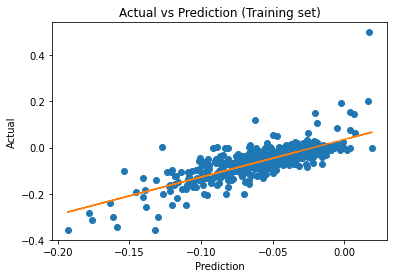

In [159]:
#plt.scatter(best_model_imp.predict(X_important_train), y_train, color='blue')
plt.plot(best_model_imp.predict(X_important_train), y_train, 'o')
m, b = np.polyfit(best_model_imp.predict(X_important_train), y_train, 1)
plt.plot(best_model_imp.predict(X_important_train), m*best_model_imp.predict(X_important_train) + b)
plt.title("Actual vs Prediction (Training set)")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [167]:
plot_data1 = {'actuals': y_train, 'predictions': best_model_imp.predict(X_important_train)}
plot_data = pd.DataFrame(plot_data1)

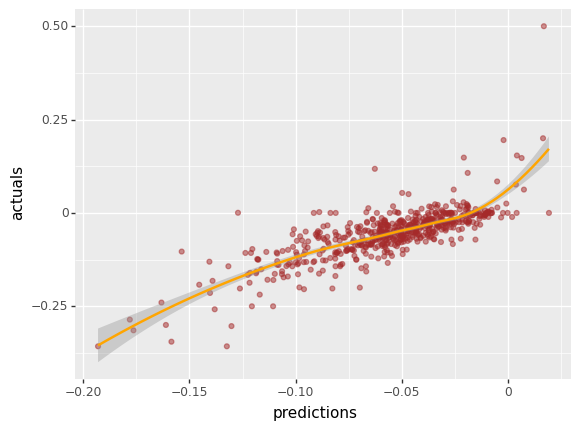

<ggplot: (317895842)>

In [188]:
fig = (
    ggplot(plot_data) +
    geom_point(
        aes(x = 'predictions',
            y = 'actuals'),
        alpha = 0.5,
        color = 'brown'
    ) +
    geom_smooth(
        aes(x = 'predictions',
            y = 'actuals'),
        color = 'orange',
        size=1
    )
)
fig

In [168]:
# final prediction on als12
best_model_imp = rnd_search_imp.best_estimator_
val_pred_imp = best_model_imp.predict(X_als12)
val_mse_imp = mean_squared_error(y_val, val_pred_imp)
val_rmse_imp = np.sqrt(val_mse_imp)
val_rmse_imp

,actuals,predictions
1517,-0.036042,-0.032529
1730,-0.053660,-0.064681
355,-0.142857,-0.101557
2480,-0.030692,-0.032163
3482,-0.162663,-0.088947
...,...,...
439,-0.192308,-0.145383
651,-0.053087,-0.089791
1663,-0.017407,-0.063594
2742,-0.157303,-0.118447


## Polynomial regression

Best degree 1 with RMSE 0.08984950352810746


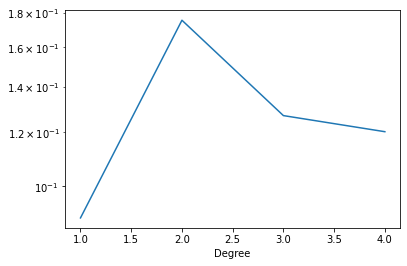

In [234]:
# Choose the best degree parameter
rmses = []
degrees = np.arange(1,5)
min_rmse, min_deg = 1e10, 0
for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_scaled)
    
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    
    X_poly_val = poly_features.fit_transform(X_val_scaled)
    poly_predict = poly_reg.predict(X_poly_val)
    poly_mse = mean_squared_error(y_val, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
        
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

fig_poly = plt.figure()
ax = fig_poly.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_label('RMSE')

In [237]:
# Use the best degree and pipleline to train data
poly_features = PolynomialFeatures(degree=1, include_bias=False)
lin_reg = LinearRegression()
polynomial_regression = Pipeline((
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
    ('lin_reg', LinearRegression()),
))

polynomial_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('poly_features',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [242]:
# Make predictions
y_val_pred = polynomial_regression.predict(X_val)

array([-0.00070721, -0.02000039, -0.03172739, -0.01553599, -0.05058144,
       -0.04925507, -0.08873503, -0.03719037, -0.06306668, -0.07002931,
       -0.05096554, -0.06910281, -0.03991518, -0.01492438, -0.07924728,
       -0.07585928, -0.06342989, -0.04444504, -0.04394425, -0.07665149,
       -0.07276047, -0.0270497 , -0.05790144, -0.09035701, -0.03854855,
       -0.076725  , -0.04352477, -0.0522852 , -0.0540114 , -0.05264571,
       -0.07007386, -0.05355148, -0.07134747, -0.10273869, -0.07361491,
       -0.03266734, -0.02792043, -0.0580997 , -0.04377025, -0.09090565,
       -0.02929531, -0.06795827, -0.09186189, -0.03960765, -0.07955273,
       -0.03413239,  0.01130827, -0.04954172, -0.0695525 , -0.03308447,
       -0.03404195, -0.0085869 , -0.03456303, -0.04115803, -0.05927193,
       -0.0466902 , -0.0531248 , -0.03239074, -0.06456619, -0.06827894,
       -0.04839761, -0.0564778 , -0.0806469 , -0.08348482])

In [245]:
# Evaluation on val data
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(rmse)

0.08397990877712401


In [246]:
# Evaluation on training data
y_train_pred = polynomial_regression.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print(rmse_train)

0.06029287856937393


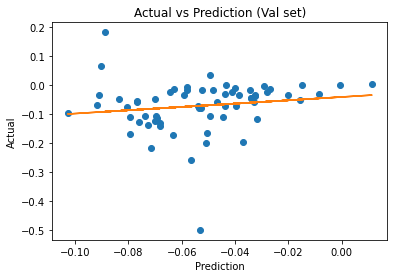

In [249]:
# Plot prediction v.s. actual
plt.plot(polynomial_regression.predict(X_val), y_val, 'o')
m, b = np.polyfit(polynomial_regression.predict(X_val), y_val, 1)
plt.plot(polynomial_regression.predict(X_val), m*polynomial_regression.predict(X_val) + b)
plt.title("Actual vs Prediction (Val set)")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [257]:
# Predict final als_12
als12_pred = polynomial_regression.predict(X_als12)
mse12 = mean_squared_error(y_als12, als12_pred)
rmse12 = np.sqrt(mse12)
print(rmse12)

0.030879902634861376


## XGBoost

In [292]:
import scipy.stats as st
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgb_reg = XGBRegressor(nthreads=-1)

In [293]:
xgb_rs = RandomizedSearchCV(xgb_reg, params, n_jobs=-1)
xgb_rs.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bytree=1, gamma=0,
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None, nthreads=-1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_we...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12f1a74e0>,
                                        'n_estimators': [200, 400, 600, 800,
                       

In [294]:
print(xgb_rs.best_params_)

{'colsample_bytree': 0.701919961446498, 'gamma': 5.319267659278406, 'learning_rate': 0.21736647396105208, 'max_depth': 90, 'min_child_weight': 63.25395683764123, 'n_estimators': 400, 'reg_alpha': 1.4642300897447786, 'subsample': 0.9676828709557957}


In [295]:
best_xgb = xgb_rs.best_estimator_
y_val_pred = best_xgb.predict(X_val_scaled)
mse_xgb = mean_squared_error(y_val, y_val_pred)
rmse_xgb = np.sqrt(mse_xgb)
print(rmse_xgb)

0.09002465253802235


In [297]:
## pipeline of gxboost
## final als12 prediction
# pipeline for random forest
best_xgb = xgb_rs.best_estimator_
xgb_pipeline = Pipeline((
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('xgb_reg', best_xgb),
))

xgb_pipeline.fit(X_train, y_train)

y_val_pred = xgb_pipeline.predict(X_val)
mse_xgb = mean_squared_error(y_val, y_val_pred)
rmse_xgb = np.sqrt(mse_xgb)
print(rmse_xgb)

0.08997976186337689
